In [1]:
!pip install git+https://github.com/ludanortmun/itesm-mna-barred-galaxies.git -q

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 51.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 298.0/298.0 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 101.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 863.4/863.4 kB 39.6 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ipython 7.34.0 requires jedi>=0.16, which is not installed.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.2.3 which is incompatible.


In [2]:
import pandas as pd
from bargal.images.client import GalaxyImageClient
import matplotlib.pyplot as plt
import cv2

In [3]:
dataset_path = '/content/dataset.csv'
img_directory = '/content/Imagenes'

df = pd.read_csv(dataset_path)
img_client = GalaxyImageClient(storage_path=img_directory)

In [4]:
def get_random_galaxy(label=None):
    if label is None:
        return df.sample(1).to_dict(orient='records')[0]

    return df[df.Bars == label].sample(1).to_dict(orient='records')[0]

In [5]:
g = get_random_galaxy(label=1)
observation = img_client.get_as_observation(g, save_to_disk=True, use_fits=False)

In [6]:
# Parametros de ajuste de imagen

zoom_factor = 4    # Nivel de zoom deseado
threshold = 15     # Umbral de cambio de intensidad para mejorar el cálculo de diametro

# Cálculo del centro de la imagen

img_rgb = observation.rgb_repr
h, w, _ = img_rgb.shape            # El tamaño original de la imagen es de 800x800
cx, cy = w // 2, h // 2

# Cálculo del centro con base en el zoom deseado

zoom_w = int(w / zoom_factor)
zoom_h = int(h / zoom_factor)
x1 = max(cx - zoom_w // 2, 0)
x2 = min(cx + zoom_w // 2, w)
y1 = max(cy - zoom_h // 2, 0)
y2 = min(cy + zoom_h // 2, h)

img_zoom = img_rgb[y1:y2, x1:x2]

# Conversión de la imagen a escala de grises

gray = cv2.cvtColor(img_zoom, cv2.COLOR_RGB2GRAY)


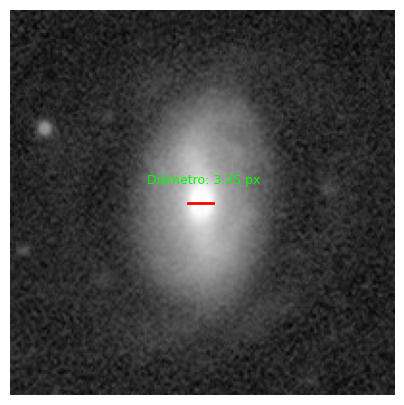

In [7]:
# Definición del borde horizontal

h_z, w_z = gray.shape
cx_z, cy_z = w_z // 2, h_z // 2

right_x = cx_z
while right_x < w_z - 1 and abs(int(gray[cy_z, right_x]) - int(gray[cy_z, cx_z])) < threshold:
    right_x += 1

left_x = cx_z
while left_x > 0 and abs(int(gray[cy_z, left_x]) - int(gray[cy_z, cx_z])) < threshold:
    left_x -= 1

diameter_px = right_x - left_x

# Cálculo del diámetro corregido para no considerar el zoom aplicado
diameter_corrected = diameter_px / zoom_factor

# Visualización del diámetro calculado

plt.figure(figsize=(5, 5))
plt.imshow(gray, cmap='gray')
plt.plot([left_x, right_x], [cy_z, cy_z], color='red', linewidth=2)
plt.text(cx_z, cy_z - 10, f"Diámetro: {diameter_corrected:.2f} px", color='lime', ha='center', fontsize=9)
plt.axis('off')
plt.show()

# **JUSTIFICACIÓN DE CÁLCULO**
##### - El diámetro calculado esta dado en pixeles con base en el tamaño original de la imagen que es 800x800.
##### - Aunque se aplica un zoom de 4x para mostrar la imágen final, este ajuste no afecta la medición final del tamaño mostrado.
##### - El diámetro fue estimado a partir del cambio de intensidad desde el centro de la galaxia hacia los extremos, utilizando un umbral de contraste para identificar el borde estructural de la galaxia.